# The Alongshore Transporter Class
AlongshoreTransporter is a stand-alone module in BRIE for diffusing sediment along a straight (non-complex) coast. The formulations are detailed in Neinhuis and Lorenzo-Trueba, 2019 [1] and Nienhuis et al., 2015 [2], but stem primarily from the alongshore transport model of Ashton and Murray, 2006 [3]. This notebook provides additional documentation for understanding the functions that comprise AlongshoreTransporter. We first provide AlongshoreTransporter with an arbitrary coastline and then explain the implementation of AlongshoreTransporter within BRIE.

<div>
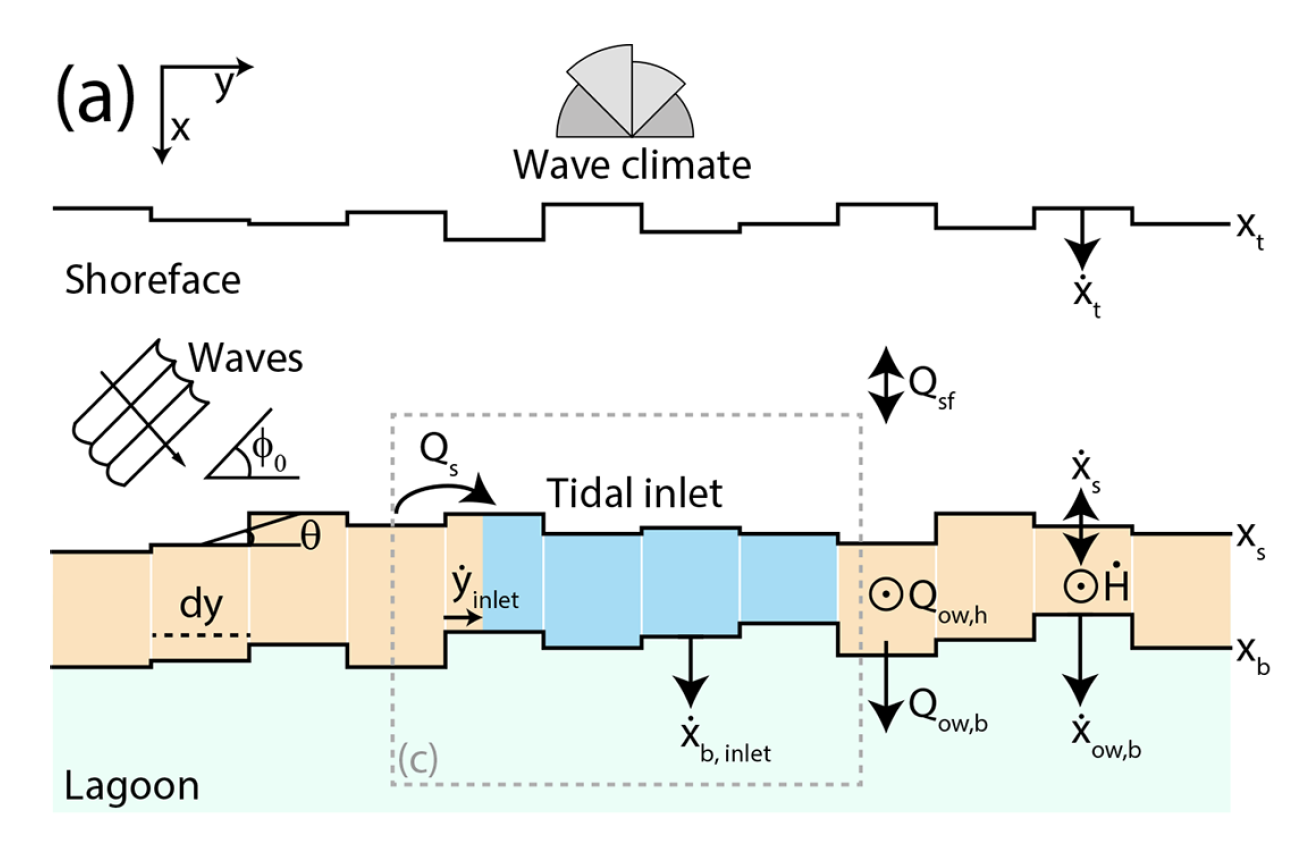
</div> 

**Figure 1. Orientation of the coastline for the AlongshoreTransporter class (Figure from NLT19).**

## Initialization
AlongshoreTransporter must be initialized with a shoreline array; the remaining variables are optional. If a wave distribution is not provided, a uniform distribution is applied from -90 to 90 degrees. Here, we are going to provide the AM06 wave distribution (`ashton`), which divides [0, 1] into quartiles that are uniform distributions defined by the shape parameters $a$ (the asymmetry) and $h$ (high fraction). 

Text(0,0.5,'cross-shore x (m)')

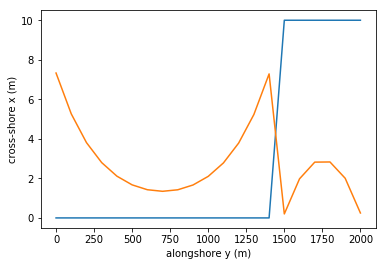

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.constants
import sys
sys.path.append("..")

from brie.alongshore_transporter import AlongshoreTransporter, calc_shoreline_angles, calc_coast_diffusivity, _build_matrix
from brie.waves import ashton, WaveAngleGenerator

shoreline_x = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 10]  # shoreline array
waves = ashton(a=0.5, h=0, loc=-np.pi/2, scale=np.pi)  # wave distribution from -90 to 90 degrees
# waves = WaveAngleGenerator(asymmetry=0.5, high_fraction=0)  # our old wave_angle_generator class

# initialize AlongshoreTransporter
transporter = AlongshoreTransporter(shoreline_x, 
                                    wave_distribution=waves, 
                                    alongshore_section_length=100, 
                                    time_step=1)  
transporter.update()  # advance one time step

# plot shoreline change after 1 model years
plt.plot(np.arange(0, np.size(shoreline_x)*100, 100), shoreline_x)  # initial shoreline
plt.plot(np.arange(0, np.size(shoreline_x)*100, 100), transporter.shoreline_x)
plt.xlabel('alongshore y (m)')
plt.ylabel('cross-shore x (m)')

**Figure 2. An example shoreline change after one model year using AlongshoreTransporter for a symmetric wave climate**

Once we initialize *AlongshoreTranporter*, we advance the model by one timestep using the `update` function. This example, while ugly, illustrates the periodic boundary conditions used in calculating shoreline diffusivity, explained in more detail below. 

### Wave distribution and shoreline angles
The incoming offshore wave angle $\phi$ shown in Figure 1 is measured counter-clockwise from the positive x-axis (to the wave front). Hence, in this offshore-looking orientation, a wave angle of -90 degrees corresponds to waves approaching from the right and 90 degrees from the left. For a wave asymmetry of 0.8 and highness of 0.2, we are defining a distribution where 80% of the waves approach from the left looking offshore and 20% of the waves approach at angles higher than 45 degrees (from shore normal). This is a little bit of a mind game because looking at the array above, values $>$0 degrees are on the right-side of the array, but keep telling yourself, these waves are coming from the left! 

In [10]:
# an example wave angle array
angle_array, step = np.linspace(-89.5, 89.5, 5, retstep=True)  # not including the boundaries
# angle_array, step = np.linspace(-90, 90, 5, retstep=True)
print('example wave angle array =', angle_array)

# and corresponding pdf
print('wave pdf =', waves.pdf(np.deg2rad(angle_array)) * np.deg2rad(step))

example wave angle array = [-89.5  -44.75   0.    44.75  89.5 ]
wave pdf = [0.         0.49722222 0.49722222 0.49722222 0.        ]


Upon initialization of *AlongshoreTransporter* (i.e., within the `__init__` function), we use the function `calc_shoreline_angles` to calculate the coastline angles of the series of (equally spaced) coastline positions with respect to the *x*-axis ($\theta$ in Figure 1), and from the perspective of looking offshore (from the shoreline). Angles at the first and last points are calculated using wrap-around boundaries. Here we provide a more simple shoreline for easy interpretation.

In [11]:
# calculate shoreline angles
shoreline_x = [0, 0, 1, 0, 0]  # shoreline array
dy = 1  # m
shoreline_angles = calc_shoreline_angles(shoreline_x, spacing=dy)
print('shoreline angles =', np.rad2deg(shoreline_angles))

shoreline angles = [  0.  45. -45.   0.   0.]


## The `update` function

Now lets look under the hood at the functions that are called within `update`. Sediment is diffused along the shoreline using a nonlinear diffusion formulation given by AM06 (Eq. 37-39 in NLT19), which is convolved with the wave climate pdf (the normalized angular distribution of wave energy) to get a *wave-climate averaged shoreline diffusivity* for every alongshore location. Erm, what? Lets break it down. 

Diffusivity $D$ depends on the relative wave angle $\phi_0-\theta$: from AM06, we know that diffisuvity "decreases from a maximum for waves approaching directly onshore, passes through zero at the angle maximizing alongshore sediment transport (Qs), and becomes negative for even more oblique wave angles". In *AlongshoreTransporter*, diffusivity is calculated in the function `calc_coast_diffusivity`. For a symmetric wave climate and a straight shoreline (i.e., $\theta=0$), $Qs$ is maximized for waves approaching at $\pm$45 degrees and maximum diffusivity occurs at 0 degrees (Figure 3a). For the assymetric wave climate defined below -- that is, where 80% of the waves come from the left and therefore from positive-valued offshore wave angles -- the maximum diffusivity is shifted to the right (Figure 3b). 

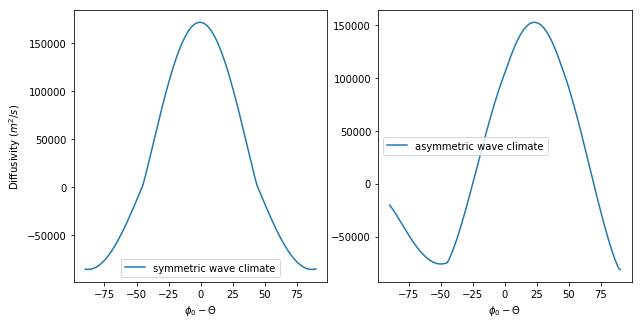

In [13]:
# symmetric wave climate
n_bins = 181  # The number of bins used for the wave resolution: if 181, symmetrical about zero, spaced by 1 deg
# waves_sym = WaveAngleGenerator(asymmetry=0.5, high_fraction=0)
waves_sym = ashton(a=0.5, h=0, loc=-np.pi/2, scale=np.pi) 
coast_diff_sym, coast_diff_phi0_theta = calc_coast_diffusivity(
    waves_sym.pdf, shoreline_angles, wave_height=1.0, wave_period=10.0, berm_ele=2.0, n_bins=n_bins
)

# plot diffusivity as a function of relative wave angle
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
# rel_wave_angles, step = np.linspace(-89.5, 89.5, 180, retstep=True)  # here, one degree of resolution per bin
rel_wave_angles, step = np.linspace(-90, 90, n_bins, retstep=True)  # here, one degree of resolution per bin
plt.plot(rel_wave_angles, coast_diff_phi0_theta)
plt.xlabel('$\phi_0 - \Theta$')
plt.ylabel('Diffusivity ($m^2/s$)')
plt.legend(["symmetric wave climate"])

# assymetric wave climate with some high angle waves (80% coming from the left)
# waves_asym = WaveAngleGenerator(asymmetry=0.2, high_fraction=0.2)
waves_asym = ashton(a=0.2, h=0.2, loc=-np.pi/2, scale=np.pi) 
coast_diff_asym, coast_diff_phi0_theta = calc_coast_diffusivity(
    waves_asym.pdf, shoreline_angles, wave_height=1.0, wave_period=10.0, berm_ele=2.0, n_bins=n_bins
)

# plot diffusivity as a function of relative wave angle
plt.subplot(1, 2, 2)
plt.plot(rel_wave_angles, coast_diff_phi0_theta)
plt.xlabel('$\phi_0 - \Theta$')
plt.legend(['asymmetric wave climate'])

**Figure 3. Shoreline diffusivity for a) a symmetric wave climate and b) an asymmetric wave climate.**

Now what does this mean in terms of shoreline change? If we evaluate $D(-\theta)$ for the simple shoreline position above (i.e., at the relative wave angles), we can see the direction of coastal diffusion at each alongshore grid cell.

In [14]:
print('relative wave angles =', -np.rad2deg(shoreline_angles))
print('shoreline diffusivity (a=0.5) = ', coast_diff_sym)
print('shoreline diffusivity (a=0.2) = ', coast_diff_asym)

relative wave angles = [ -0. -45.  45.  -0.  -0.]
shoreline diffusivity (a=0.5) =  [171927.32384865   2208.81484642  -1009.81725545 171927.32384865
 171927.32384865]
shoreline diffusivity (a=0.2) =  [105047.67304441 -74650.04019369 108489.02402821 105047.67304441
 105047.67304441]


Now that we know the diffusivity at each point, we have all of the variables needed to solve the shoreline diffusion equation (Equation 40 in NLT19). We solve this linear diffusion equation by inverting a nearly tridiagonal matrix, which is created using the `_build_matrix` function. Note that all of the functions we've utilized so far (`calc_coast_diffusivity`, `calc_shoreline_angles`) are called within `_build_matrix`. Figure 3 shows an example of shoreline change for a more realistic shoreline position -- a small delta -- for both the symmetric and assymetric wave climate described above, for a 100-m alongshore grid discretization and 1-yr time-step.

Text(0,0.5,'cross-shore x (m)')

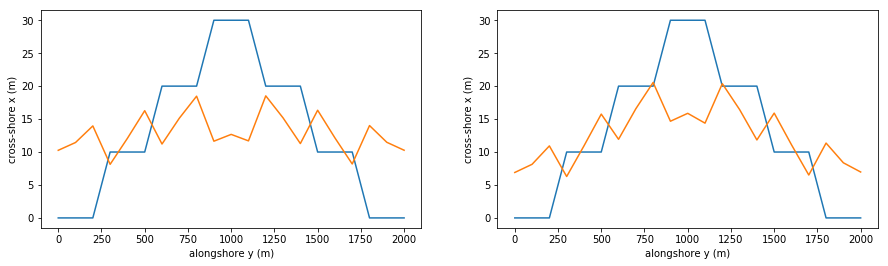

In [15]:
# create diffusion matrix for a small delta
shoreline_x_pyramid = [0, 0, 0, 10, 10, 10, 20, 20, 20, 30, 30, 30, 20, 20, 20, 10, 10, 10, 0, 0, 0]
mat, rhs, r_ipl = _build_matrix(shoreline_x_pyramid, waves_sym, dy=100, wave_height=1.0, wave_period=10.0, dt=1.0, dx_dt=0)
#print('r_ipl =', r_ipl)

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, np.size(shoreline_x_pyramid)*100, 100), shoreline_x_pyramid)

# invert matrix
shoreline_x_pyramid[:] = scipy.sparse.linalg.spsolve(mat, rhs)

# new shoreline
plt.plot(np.arange(0, np.size(shoreline_x_pyramid)*100, 100), shoreline_x_pyramid)
plt.xlabel('alongshore y (m)')
plt.ylabel('cross-shore x (m)')

# assymetric wave climate
shoreline_x_pyramid = [0, 0, 0, 10, 10, 10, 20, 20, 20, 30, 30, 30, 20, 20, 20, 10, 10, 10, 0, 0, 0]
mat, rhs, r_ipl = _build_matrix(shoreline_x_pyramid, waves_asym, dy=100, wave_height=1.0, wave_period=10.0, dt=1.0, dx_dt=0)
#print('r_ipl =', r_ipl)

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, np.size(shoreline_x_pyramid)*100, 100), shoreline_x_pyramid)

# invert matrix
shoreline_x_pyramid[:] = scipy.sparse.linalg.spsolve(mat, rhs)

# new shoreline
plt.plot(np.arange(0, np.size(shoreline_x_pyramid)*100, 100), shoreline_x_pyramid)
plt.xlabel('alongshore y (m)')
plt.ylabel('cross-shore x (m)')

**Figure 4. Shoreline change after one model year for a) a symmetric wave climate and b) an asymmetric wave climate.**

As you can see in Figure 4, because we convolved the wave climate pdf (the normalized angular distribution of wave energy) to get a wave-climate averaged shoreline diffusivity for every alongshore location, the difference in shoreline change due to wave asymmetry (for a given wave height and period) is subtle.

# Implementation in BRIE model